<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/SONIA-time-steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Los datos del conjunto de datos de ciclismo bicicletas se agrupan por "Hora de inicio", lo que representa el recuento de nuevas bicicletas compartidas agrupadas por hora. Las acciones de larga duración no se toman en cuenta.

El propósito es intentar predecir las futuras bicicletas compartidas.

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description: 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [6]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional

In [8]:
import seaborn as sns

In [9]:
data = pd.read_csv('/content/london_merged.csv')

In [10]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [11]:
data.shape

(17414, 10)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [13]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [14]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

In [15]:
'''
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year


#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values


In [16]:
estacion = data['season'].values
festivo = data['is_holiday'].values


In [17]:
data["year_month"] = data.index.strftime('%Y-%m')

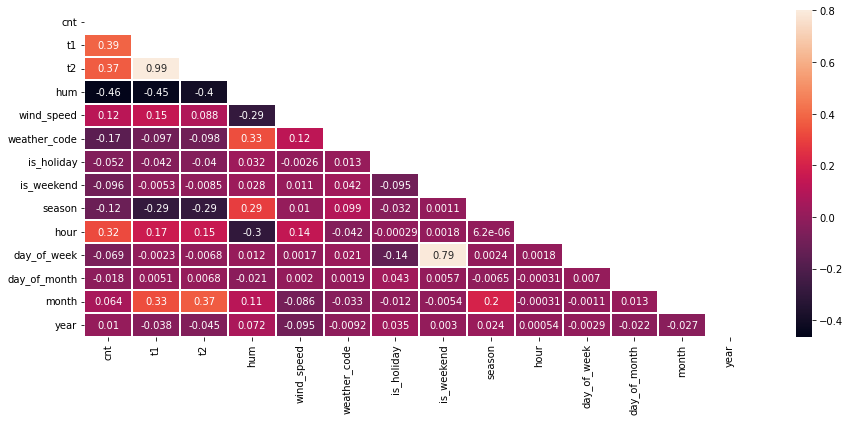

In [18]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

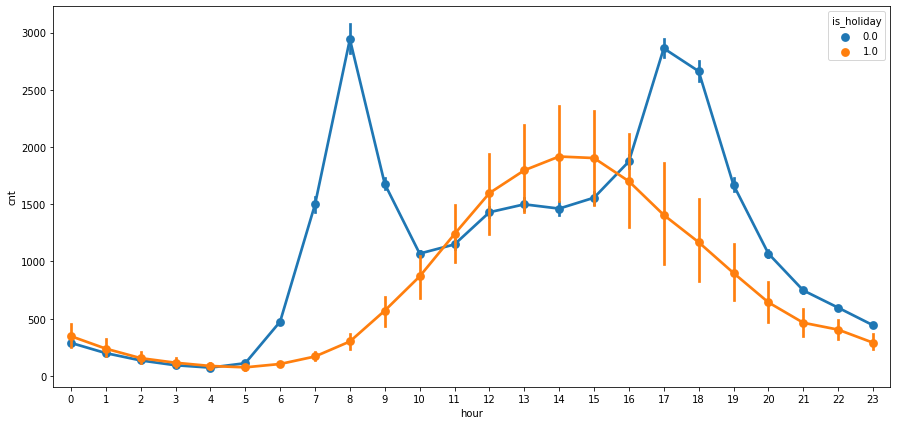

In [19]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

In [20]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year,year_month
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015,2015-01
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015,2015-01
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015,2015-01
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015,2015-01
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1,2015,2015-01


In [21]:
data_final = data[['t1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'hour',
 'month',
 'cnt'
 ]]

In [22]:
data_final.head()

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
timestamp,,,,,,,,,,
2015-01-04 00:00:00,3.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,182
2015-01-04 01:00:00,3.0,93.0,5.0,1.0,0.0,1.0,3.0,1,1,138
2015-01-04 02:00:00,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,134
2015-01-04 03:00:00,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,72
2015-01-04 04:00:00,2.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,47


In [23]:
data_final = data_final.reset_index()

In [24]:
std_cnt = data.cnt.std()
std_cnt

1085.1080679362167

In [25]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/std_cnt
def inverse_transform(x_escalado):
    return x_escalado*std_cnt

In [26]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(data_final[f_columns].to_numpy())

data_final.loc[:, f_columns] = f_transformer.transform(
    data_final[f_columns].to_numpy()
)

In [27]:
data_final['cnt'] = transform(data_final['cnt'])

In [28]:
data_final.head()

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3.0,0.0,1.0,3.0,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1.0,0.0,1.0,3.0,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1.0,0.0,1.0,3.0,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1.0,0.0,1.0,3.0,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1.0,0.0,1.0,3.0,4,1,0.043314


In [29]:
data_final["season"] = data_final["season"].astype(int)
data_final["is_weekend"] = data_final["is_weekend"].astype(int)
data_final["is_holiday"] = data_final["is_holiday"].astype(int)
data_final["weather_code"] = data_final["weather_code"].astype(int)

In [30]:
data_final.head(5)

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1,0,1,3,4,1,0.043314


In [31]:
data_final.drop(['weather_code'], axis = 'columns')

,timestamp,t1,hum,wind_speed,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,0,1,3,4,1,0.043314
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,-0.9375,0.325,0.380952,0,0,3,19,1,0.960273
17410,2017-01-03 20:00:00,-0.9375,0.325,0.571429,0,0,3,20,1,0.498568
17411,2017-01-03 21:00:00,-0.8750,0.200,0.857143,0,0,3,21,1,0.310568
17412,2017-01-03 22:00:00,-0.8750,0.075,0.761905,0,0,3,22,1,0.206431


In [32]:
t1 = data_final['t1'].values
hum = data_final['hum'].values
wind_speed = data_final['wind_speed'].values
is_weekend = data_final['is_weekend'].values

In [33]:
tiempo = data_final['weather_code'].values
festivo = data_final['is_holiday'].values
#is_weekend
#season
#year
estacion = data_final['season'].values
mes = data_final['month'].values
#dia = data_final['day_of_week'].values
hora = data_final['hour'].values

In [34]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [35]:
one_hot_mes = int2dummy(mes, 1, 12)
one_hot_hora = int2dummy(hora, 0, 23)
one_hot_estacion = int2dummy(estacion, 0, 3)

In [36]:
#timestamp	t1	hum	wind_speed	is_holiday	is_weekend	season	hour	month	cnt

In [37]:
target_transf = transform(target)

series = [target_transf, t1, hum, wind_speed, is_weekend, festivo]
se_saben_antes = [False, True, True, True, True, True]
nombres_series = ["target_transf", "t1", "hum", "wind_speed", "is_weekend", "festivo"]

# Variables calendario sobre las que hemos hecho one-hot encoding
for i in range(one_hot_mes.shape[1]):
    series.append(one_hot_mes[:,i])
    nombres_series.append("mes"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_hora.shape[1]):
    series.append(one_hot_hora[:,i])
    nombres_series.append("semana"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_estacion.shape[1]):
    series.append(one_hot_estacion[:,i])
    nombres_series.append("day"+str(i+1))
    se_saben_antes.append(True)

In [38]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(46, 17414)
(46,)


In [50]:
data_final

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1,0,1,3,4,1,0.043314
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,-0.9375,0.325,0.380952,3,0,0,3,19,1,0.960273
17410,2017-01-03 20:00:00,-0.9375,0.325,0.571429,4,0,0,3,20,1,0.498568
17411,2017-01-03 21:00:00,-0.8750,0.200,0.857143,4,0,0,3,21,1,0.310568
17412,2017-01-03 22:00:00,-0.8750,0.075,0.761905,4,0,0,3,22,1,0.206431


# Enventanar

In [41]:
lookback = 48 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback, W_out=24)

print(X.shape, np.shape(y))

(17414, 48, 46) (17414, 24)


In [ ]:
print(X.shape)
print(np.shape(target))

(17414, 48, 46)
(17414,)


In [ ]:
y.shape()

TypeError: ignored

In [ ]:
print(y[-23:, :])#48 time steps y 8 features, var. contexto

[[0.04515679 0.03962739 0.00921567 0.02764702 0.07649008 0.39996016
  1.29664505 2.67623114 1.25056669 0.60915592 0.58611674 0.76029294
  0.809136   0.70499891 0.77872428 1.1068022  2.52693725 2.04587918
  0.96027302 0.49856785 0.31056815 0.20643105 0.12809784        nan]
 [0.03962739 0.00921567 0.02764702 0.07649008 0.39996016 1.29664505
  2.67623114 1.25056669 0.60915592 0.58611674 0.76029294 0.809136
  0.70499891 0.77872428 1.1068022  2.52693725 2.04587918 0.96027302
  0.49856785 0.31056815 0.20643105 0.12809784        nan        nan]
 [0.00921567 0.02764702 0.07649008 0.39996016 1.29664505 2.67623114
  1.25056669 0.60915592 0.58611674 0.76029294 0.809136   0.70499891
  0.77872428 1.1068022  2.52693725 2.04587918 0.96027302 0.49856785
  0.31056815 0.20643105 0.12809784        nan        nan        nan]
 [0.02764702 0.07649008 0.39996016 1.29664505 2.67623114 1.25056669
  0.60915592 0.58611674 0.76029294 0.809136   0.70499891 0.77872428
  1.1068022  2.52693725 2.04587918 0.96027302 0

In [ ]:
x_ = X[:-23, :, :]
y_ = y[:-23, :]

In [ ]:
print(x_.shape, np.shape(y_))

(17391, 48, 46) (17391, 24)


In [ ]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [ ]:
X_train      = x_[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y_[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
#fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = x_[punto_corte:]
y_test       = y_[punto_corte:]
target_test  = target[punto_corte:]
#fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(13883,)
(3483,)


In [ ]:
print(X_train.shape, y_train.shape)

(13883, 48, 46) (13883, 24)


In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))  # input_shape=[time steps, features]
model_0.add(Dense(100, activation='relu'))
model_0.add(Dense(n_outputs))
model_0.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

In [ ]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               197600    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 24)                2424      
                                                                 
Total params: 220,124
Trainable params: 220,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_model_0 = model_0.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
391/391 [==============================] - 49s 115ms/step - loss: 0.6225 - val_loss: 0.4324
Epoch 2/100
391/391 [==============================] - 46s 117ms/step - loss: 0.2473 - val_loss: 0.2931
Epoch 3/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1790 - val_loss: 0.2521
Epoch 4/100
391/391 [==============================] - 45s 116ms/step - loss: 0.1498 - val_loss: 0.2490
Epoch 5/100
391/391 [==============================] - 45s 114ms/step - loss: 0.1275 - val_loss: 0.3230
Epoch 6/100
391/391 [==============================] - 45s 116ms/step - loss: 0.1142 - val_loss: 0.2825
Epoch 7/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1686 - val_loss: 0.2986
Epoch 8/100
391/391 [==============================] - 44s 113ms/step - loss: 0.1268 - val_loss: 0.2734
Epoch 9/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1031 - val_loss: 0.2688
Epoch 10/100
391/391 [==============================] - 45s 116m

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history_model_0.history['loss'], label='Training loss')
plt.plot(history_model_0.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

NameError: ignored

In [ ]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
epochs = 100
batch_size = 32
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model_0.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model_0.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)


Epoch 1: val_mse improved from inf to 0.60246, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.60246 to 0.33128, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.33128 to 0.24894, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.24894

Epoch 1: val_mse improved from 0.24894 to 0.23830, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.23830 to 0.19653, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.19653 to 0.17405, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.17405


KeyboardInterrupt: ignored

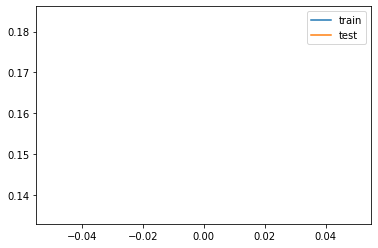

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# Nueva forma

In [39]:
# lag (horas pasadas usadas para pronosticar)
# n_ahead (pasos que queremos pronosticar)


def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:

    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [41]:
# Number of lags (hours back) to use for models
lag = 48
# Steps ahead to forecast 
n_ahead = 1 #num outputs 
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 32
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 10
# The features used in the modeling 
features_final = ["target_transf", "t1", "hum", "wind_speed", "is_weekend", "festivo"]

In [42]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [47]:
test_share

0.1

In [63]:
features_final = ['cnt',
                't1',
                'hum',
                'wind_speed',
                'is_holiday',
                'is_weekend',
                'season',
                'hour',
                'month']

In [64]:
ts = data_final[features_final]

In [90]:
ts.head()

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,season,hour,month
0,0.167725,-1.1875,0.925,-0.857143,0,1,3,0,1
1,0.127176,-1.1875,0.925,-0.952381,0,1,3,1,1
2,0.123490,-1.2500,1.100,-1.428571,0,1,3,2,1
3,0.066353,-1.3125,1.275,-1.428571,0,1,3,3,1
4,0.043314,-1.3125,0.925,-0.809524,0,1,3,4,1


In [100]:
nrows

17414

In [80]:
# Subseting only the needed columns 
ts = data_final[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1-test_share))]
test = ts[int(nrows * (1-test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [82]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [86]:
print("Shape of training data: ", Xtrain.shape)
print("Shape of the target data: ", Ytrain.shape)
print("Shape of validation data: ", Xval.shape)
print("Shape of the validation target data: ", Yval.shape)

Shape of training data:  (15628, 48, 9)
Shape of the target data:  (15628, 1)
Shape of validation data:  (1737, 48, 9)
Shape of the validation target data:  (1737, 1)


In [106]:
print(Xtrain.shape[1])
print(Xtrain.shape[2])

48
9


In [109]:
model_0 = Sequential()
model_0.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))  # input_shape=[time steps, features]
model_0.add(Dense(units = 512, activation = 'relu'))
model_0.add(Dense(n_ahead))
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [110]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 224       
                                                                 
 dense_2 (Dense)             (None, 512)               2560      
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [112]:
history_lstm = model_0.fit(Xtrain, Ytrain, epochs=20, validation_split=0.1, batch_size=32)

Epoch 1/20
440/440 [==============================] - 10s 16ms/step - loss: 0.5318 - val_loss: 0.4714
Epoch 2/20
440/440 [==============================] - 7s 15ms/step - loss: 0.2871 - val_loss: 0.3152
Epoch 3/20
440/440 [==============================] - 7s 15ms/step - loss: 0.1955 - val_loss: 0.2085
Epoch 4/20
440/440 [==============================] - 6s 15ms/step - loss: 0.1303 - val_loss: 0.1261
Epoch 5/20
440/440 [==============================] - 6s 15ms/step - loss: 0.0956 - val_loss: 0.1034
Epoch 6/20
440/440 [==============================] - 6s 15ms/step - loss: 0.0791 - val_loss: 0.0760
Epoch 7/20
440/440 [==============================] - 7s 15ms/step - loss: 0.0694 - val_loss: 0.0653
Epoch 8/20
440/440 [==============================] - 7s 15ms/step - loss: 0.0642 - val_loss: 0.0650
Epoch 9/20
440/440 [==============================] - 7s 15ms/step - loss: 0.0594 - val_loss: 0.0639
Epoch 10/20
440/440 [==============================] - 7s 15ms/step - loss: 0.0554 - val_l

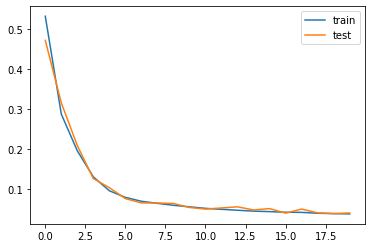

In [113]:
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend();

In [137]:
# make predictions
#y_pred_test = model_0.predict(Xval)
y_pred_train = model_0.predict(Xtrain)

ValueError: ignored

In [ ]:
# invert scaling

y_train_inv = inverse_transform(Ytrain.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = inverse_transform(Yval.reshape(1, -1))
y_pred_test_inv = inverse_transform(y_pred_test)
y_pred_train_inv = inverse_transform(y_pred_train)

In [ ]:
#####

In [114]:
# Number of lags (hours back) to use for models
lag = 168 #ultimos 7 días
# Steps ahead to forecast 
n_ahead = 24 #num outputs 
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 20
# Batch size 
batch_size = 32
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 10
# The features used in the modeling 
features_final = ["target_transf", "t1", "hum", "wind_speed", "is_weekend", "festivo"]

In [116]:
data_final

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1,0,1,3,4,1,0.043314
...,...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,-0.9375,0.325,0.380952,3,0,0,3,19,1,0.960273
17410,2017-01-03 20:00:00,-0.9375,0.325,0.571429,4,0,0,3,20,1,0.498568
17411,2017-01-03 21:00:00,-0.8750,0.200,0.857143,4,0,0,3,21,1,0.310568
17412,2017-01-03 22:00:00,-0.8750,0.075,0.761905,4,0,0,3,22,1,0.206431


In [117]:
# Subseting only the needed columns 
#ts = data_final[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1-test_share))]
test = ts[int(nrows * (1-test_share)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [118]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [119]:
print("Shape of training data: ", Xtrain.shape)
print("Shape of the target data: ", Ytrain.shape)
print("Shape of validation data: ", Xval.shape)
print("Shape of the validation target data: ", Yval.shape)

Shape of training data:  (15499, 168, 9)
Shape of the target data:  (15499, 24)
Shape of validation data:  (1723, 168, 9)
Shape of the validation target data:  (1723, 24)


In [127]:
model_1 = Sequential()
model_1.add(LSTM(10, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))  # input_shape=[time steps, features]
model_1.add(Dense(units = 512, activation = 'relu'))
model_1.add(Dropout(rate=0.2))
model_1.add(Dense(n_ahead))
model_1.compile(loss='mean_squared_error', optimizer='adam')

In [128]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10)                800       
                                                                 
 dense_9 (Dense)             (None, 512)               5632      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 24)                12312     
                                                                 
Total params: 18,744
Trainable params: 18,744
Non-trainable params: 0
_________________________________________________________________


In [130]:
history_lstm_2 = model_1.fit(Xtrain, Ytrain, epochs=35, validation_split=0.1, batch_size=32)

Epoch 1/35
436/436 [==============================] - 22s 50ms/step - loss: 0.4197 - val_loss: 0.4448
Epoch 2/35
436/436 [==============================] - 20s 47ms/step - loss: 0.3209 - val_loss: 0.3690
Epoch 3/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2810 - val_loss: 0.3275
Epoch 4/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2615 - val_loss: 0.3143
Epoch 5/35
436/436 [==============================] - 20s 47ms/step - loss: 0.2502 - val_loss: 0.3049
Epoch 6/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2424 - val_loss: 0.2975
Epoch 7/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2351 - val_loss: 0.2900
Epoch 8/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2297 - val_loss: 0.2892
Epoch 9/35
436/436 [==============================] - 20s 46ms/step - loss: 0.2267 - val_loss: 0.2830
Epoch 10/35
436/436 [==============================] - 20s 46ms/step - loss: 0.221

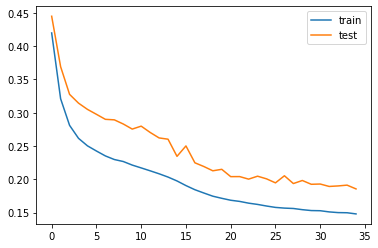

In [131]:
plt.plot(history_lstm_2.history['loss'], label='train')
plt.plot(history_lstm_2.history['val_loss'], label='test')
plt.legend();

In [138]:
# make predictions
y_pred_test = model_1.predict(Xval)
y_pred_train = model_1.predict(Xtrain)

In [164]:
# invert scaling

y_train_inv = inverse_transform(Ytrain) #flatten() creo que hace lo mismo
y_test_inv = inverse_transform(Yval)
y_pred_test_inv = inverse_transform(y_pred_test)
y_pred_train_inv = inverse_transform(y_pred_train)

In [161]:
len(y_train_inv)

15499

In [173]:
print(y_train_inv[0,:])
print(y_train_inv[1,:])

[ -897.32173485  -953.59490535 -1015.79156747 -1076.01373239
 -1092.79695868 -1082.92447263 -1057.25600889  -911.14321532
  -617.93037958  -238.82691518    83.01613011   386.10145191
   640.81159205   469.03033475   296.26182884   -66.05840927
  -332.61553268  -636.68810308  -662.35656681  -838.08681854
  -892.38549182  -915.09220974  -983.2123635  -1033.56204237]
[ -953.59490535 -1015.79156747 -1076.01373239 -1092.79695868
 -1082.92447263 -1057.25600889  -911.14321532  -617.93037958
  -238.82691518    83.01613011   386.10145191   640.81159205
   469.03033475   296.26182884   -66.05840927  -332.61553268
  -636.68810308  -662.35656681  -838.08681854  -892.38549182
  -915.09220974  -983.2123635  -1033.56204237 -1104.64394194]


In [168]:
y_train_inv

array([[ -897.32173485,  -953.59490535, -1015.79156747, ...,
         -915.09220974,  -983.2123635 , -1033.56204237],
       [ -953.59490535, -1015.79156747, -1076.01373239, ...,
         -983.2123635 , -1033.56204237, -1104.64394194],
       [-1015.79156747, -1076.01373239, -1092.79695868, ...,
        -1033.56204237, -1104.64394194, -1120.43991962],
       ...,
       [ -697.8975166 ,  -725.54047754,  -798.59687433, ...,
         -692.96127357,  -674.20355007,  -849.9338018 ],
       [ -725.54047754,  -798.59687433,  -934.83718185, ...,
         -674.20355007,  -849.9338018 ,  -949.64591092],
       [ -798.59687433,  -934.83718185, -1000.98283839, ...,
         -849.9338018 ,  -949.64591092, -1014.80431887]])

In [152]:
len(Ytrain)

15499

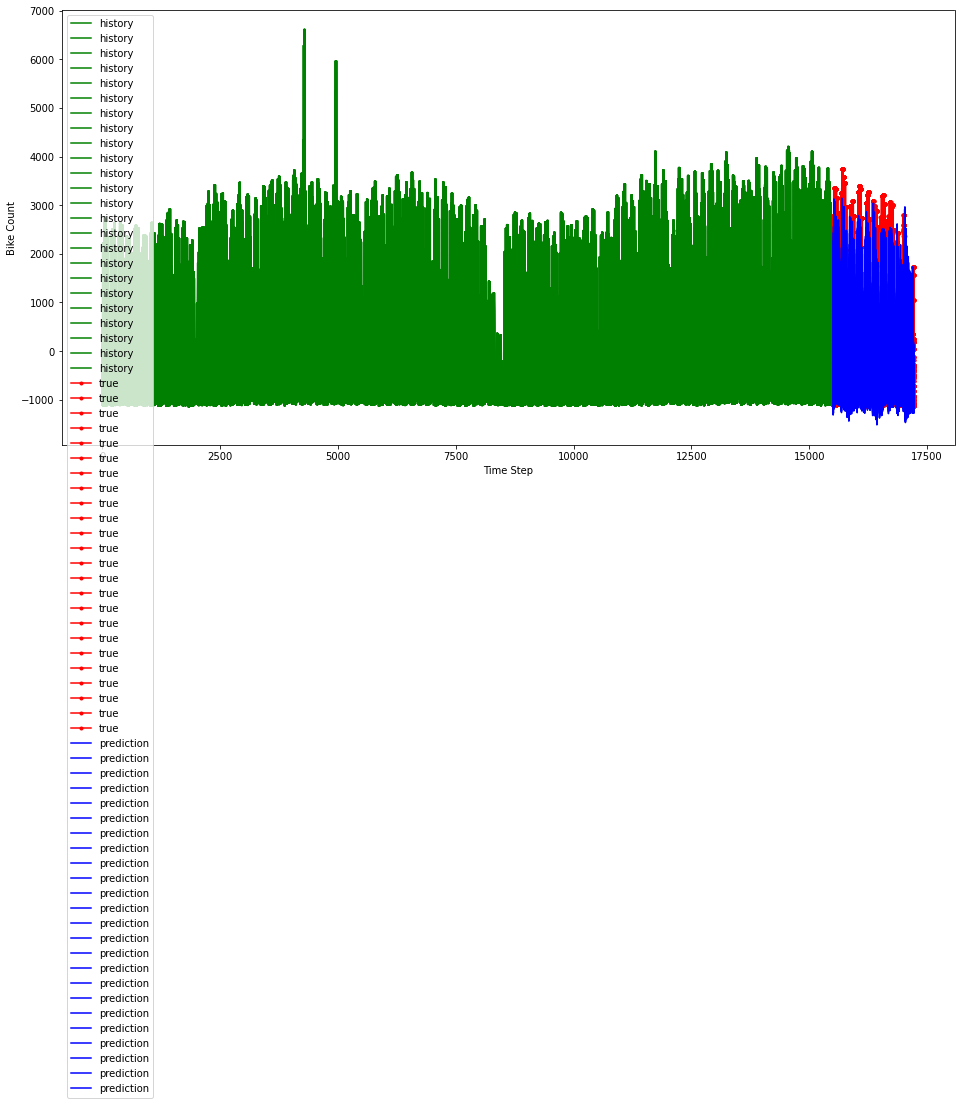

In [167]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(Ytrain)), y_train_inv, 'g', label="history")
plt.plot(np.arange(len(Ytrain), len(Ytrain) + len(Yval)), y_test_inv, 'r', marker='.', label="true")
plt.plot(np.arange(len(Ytrain), len(Ytrain) + len(Yval)), y_pred_test_inv,'b', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [174]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [176]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	#model = build_model(train, n_input)
	# history is a list of weekly data
	#history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model_1, history_lstm_2, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [180]:
score, scores = evaluate_model(train, test, n_input)

NameError: ignored

In [178]:
hour = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
plt.plot(hour, scores, marker='o', label='lstm')
plt.show()

NameError: ignored

In [185]:

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]


# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# make forecasts
forecasts = make_forecasts(model_1, 1, Xtrain, Xval, 1, 3)

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)


actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

ValueError: ignored

In [ ]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)